# SARIMAX

## 1. Sourcing and Loading

In [1]:
#!pip install seaborn

### Load relevant librarie

In [2]:
#File and name management libraries
import os
import shutil

#Math & data handling libraries
import pandas as pd
import numpy as np

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#dates and timeframe libraries
import datetime
import matplotlib.dates as mdates

#API
import requests


### Load the data

In [3]:
TARGET_FEATURE = "BTC"

In [4]:
def get_bitcoin_prices(start_date, end_date):
    try:
        # Make an HTTP GET request to the Coindesk API
        url = f"https://api.coindesk.com/v1/bpi/historical/close.json?start={start_date}&end={end_date}"
        response = requests.get(url)
        data = response.json()

        # Convert data to a Pandas DataFrame
        btc_prices = pd.DataFrame(data["bpi"].items(), columns=["Date", TARGET_FEATURE])

        btc_prices['Date'] = pd.to_datetime(btc_prices['Date'], format='%Y-%m-%d', errors="raise")

    except Exception as e:
        print(f"Error fetching Bitcoin prices: {e}")

    return btc_prices

In [5]:
# Get dates
START_DATE = "2019-01-01"
print(f"Start date: {START_DATE}")

TODAY = datetime.datetime.now().date()
print(f"Current date: {TODAY}")

PRED_STEPS = 7

BASE_DATE = TODAY - datetime.timedelta(days = PRED_STEPS)
print(f"Base date: {BASE_DATE}")

Start date: 2019-01-01
Current date: 2024-03-05
Base date: 2024-02-27


In [6]:
bitcoin_prices = get_bitcoin_prices(START_DATE, TODAY)

In [7]:
display(bitcoin_prices)

,Date,BTC
0,2019-01-01,3715.5644
1,2019-01-02,3882.3048
2,2019-01-03,3795.5927
3,2019-01-04,3812.3811
4,2019-01-05,3809.9143
...,...,...
1881,2024-02-29,60823.8397
1882,2024-03-01,62520.8425
1883,2024-03-02,61924.9269
1884,2024-03-03,63097.4688


In [8]:
sum(bitcoin_prices['BTC'] == np.nan)

0

## 2. Cleaning, transforming and visualizing

In [9]:
df = bitcoin_prices.copy()
# Fill the missing dates and relative attribute with 0
r = pd.date_range(start=df.Date.min(), end=df.Date.max())
df = df.set_index('Date').reindex(r).fillna(method='ffill').rename_axis('Date').reset_index().dropna()

# Set period/frequency using set_index() dates
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').asfreq('D').dropna()

### Type conversions

In [10]:
df.dtypes

BTC    float64
dtype: object

### Making a predictor variable `y`

In [11]:
y = df[TARGET_FEATURE][:BASE_DATE]
type(y)

pandas.core.series.Series

In [12]:
y

Date
2019-01-01     3715.5644
2019-01-02     3882.3048
2019-01-03     3795.5927
2019-01-04     3812.3811
2019-01-05     3809.9143
                 ...    
2024-02-23    50927.5343
2024-02-24    51683.0130
2024-02-25    51891.7980
2024-02-26    54505.7516
2024-02-27    56933.1495
Freq: D, Name: BTC, Length: 1884, dtype: float64

### Getting summary statistics for `y`

In [13]:
y.describe().round(2)

count     1884.00
mean     25234.47
std      16249.90
min       3360.53
25%       9784.77
50%      23012.77
75%      38106.39
max      67633.65
Name: BTC, dtype: float64

### Plot `y`

In [14]:
def plotter(y):
    fig, ax = plt.subplots(figsize=(9, 4))
    plt.plot(y.index, y)
    plt.show()

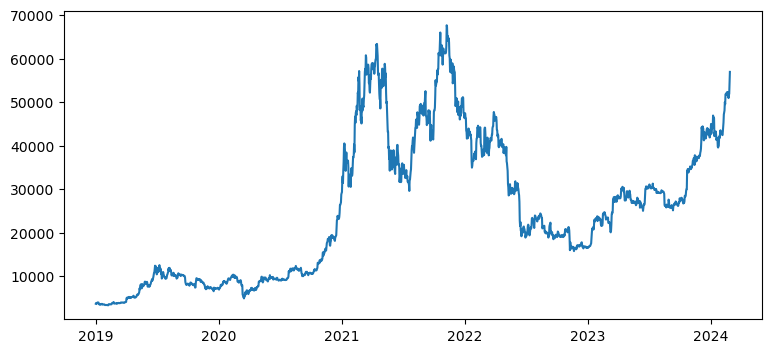

In [15]:
plotter(y)

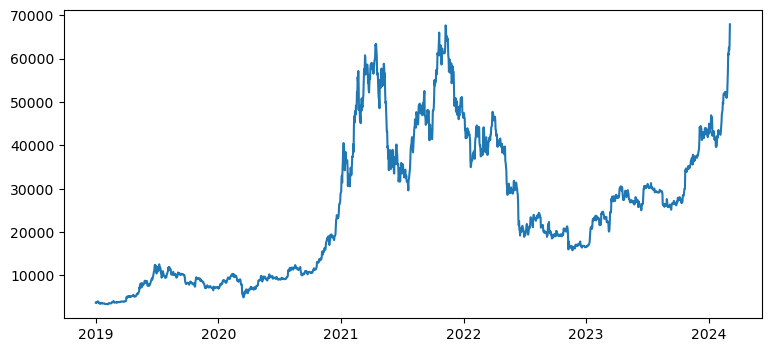

In [16]:
plotter(df)

## 3. Modeling

### Decomposition

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonal_decomposition(time_series):
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(time_series)

    # Extract the trend, seasonal, and residual components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot the original data, trend, seasonal, and residuals
    plt.figure(figsize=(9, 9))

    # Original data
    plt.subplot(411)
    plt.plot(time_series, label='Original Data')
    plt.legend(loc='best')

    # Trend component
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')

    # Seasonal component
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='best')

    # Residual component
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()


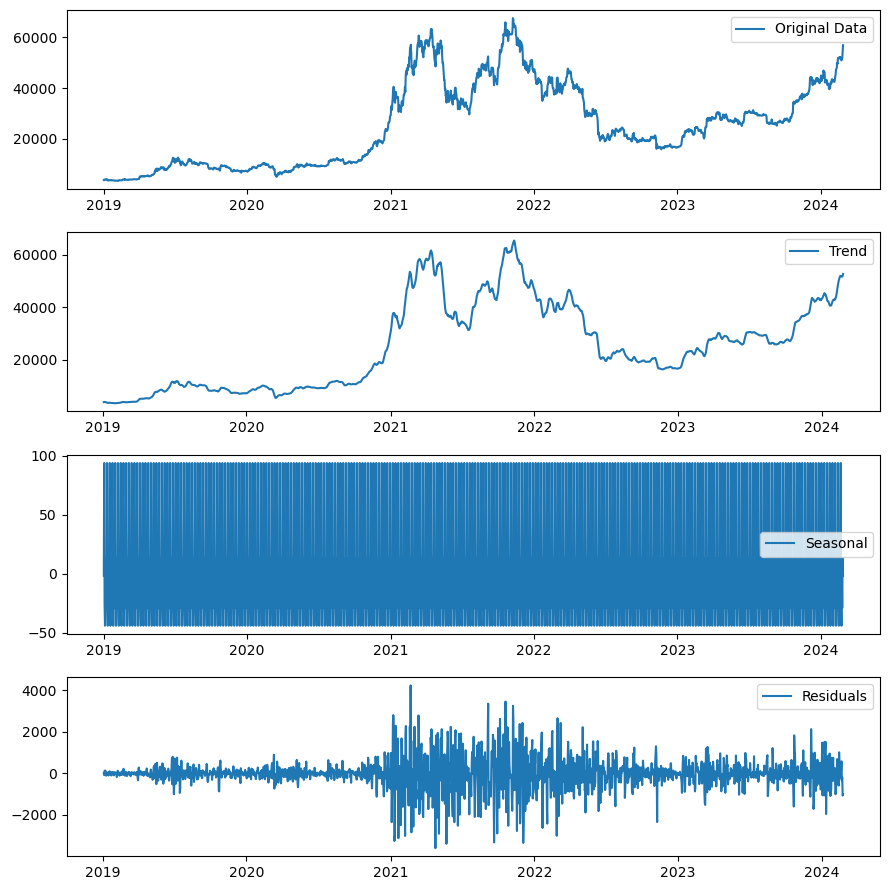

In [18]:
plot_seasonal_decomposition(y)

### Testing For Stationarity

In [19]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(time_series, p_val):
    print('Augmented Dickey-Fuller Test')
    print('Hypotheses: H0 (non-stationary) | Ha (stationary)')
    print('---------------------------')
    
    result = adfuller(time_series)
    labels = ['ADF Statistic', 'p-value', 'Number of Lags', 'Number of Observations']
    
    for value, label in zip(result, labels):
        print(label + ': ' + str(value))
        
    print('---------------------------')    
    if result[1] <= p_val:
        print("Conclusion: Strong evidence against the null hypothesis (H0).")
        print("Reject the null hypothesis. The data has no unit root and is stationary.")
    else:
        print("Conclusion: Weak evidence against the null hypothesis.")
        print("The time series has a unit root, indicating it is non-stationary.")

In [20]:
adfuller_test(y, 0.05)

Augmented Dickey-Fuller Test
Hypotheses: H0 (non-stationary) | Ha (stationary)
---------------------------
ADF Statistic: -0.9670605363107554
p-value: 0.7650878792437196
Number of Lags: 0
Number of Observations: 1883
---------------------------
Conclusion: Weak evidence against the null hypothesis.
The time series has a unit root, indicating it is non-stationary.


In [21]:
y_diff = y.diff().dropna()

In [22]:
y_diff.describe().round(2)

count    1883.00
mean       28.26
std      1009.30
min     -6009.04
25%      -234.78
50%        10.88
75%       301.97
max      6255.00
Name: BTC, dtype: float64

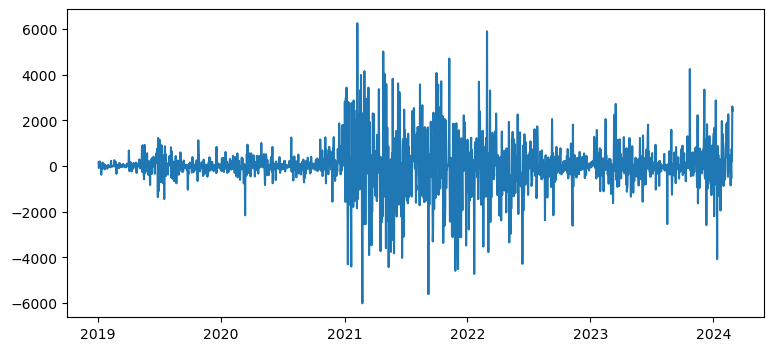

In [23]:
plotter(y_diff)

In [24]:
adfuller_test(y_diff, 0.05)

Augmented Dickey-Fuller Test
Hypotheses: H0 (non-stationary) | Ha (stationary)
---------------------------
ADF Statistic: -43.41597965825551
p-value: 0.0
Number of Lags: 0
Number of Observations: 1882
---------------------------
Conclusion: Strong evidence against the null hypothesis (H0).
Reject the null hypothesis. The data has no unit root and is stationary.


### ACF & PACF Plots

In [25]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(time_series, max_lags=50):
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    
    # Plot the ACF
    plot_acf(time_series, lags=max_lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')
    
    # Plot the PACF
    plot_pacf(time_series, lags=max_lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()

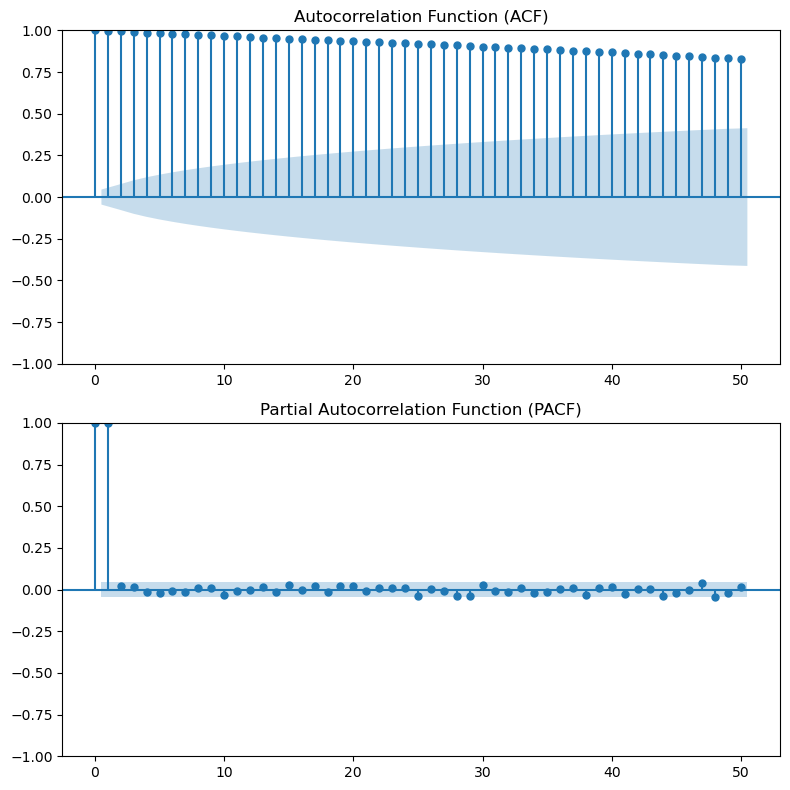

In [26]:
plot_acf_pacf(y,50)

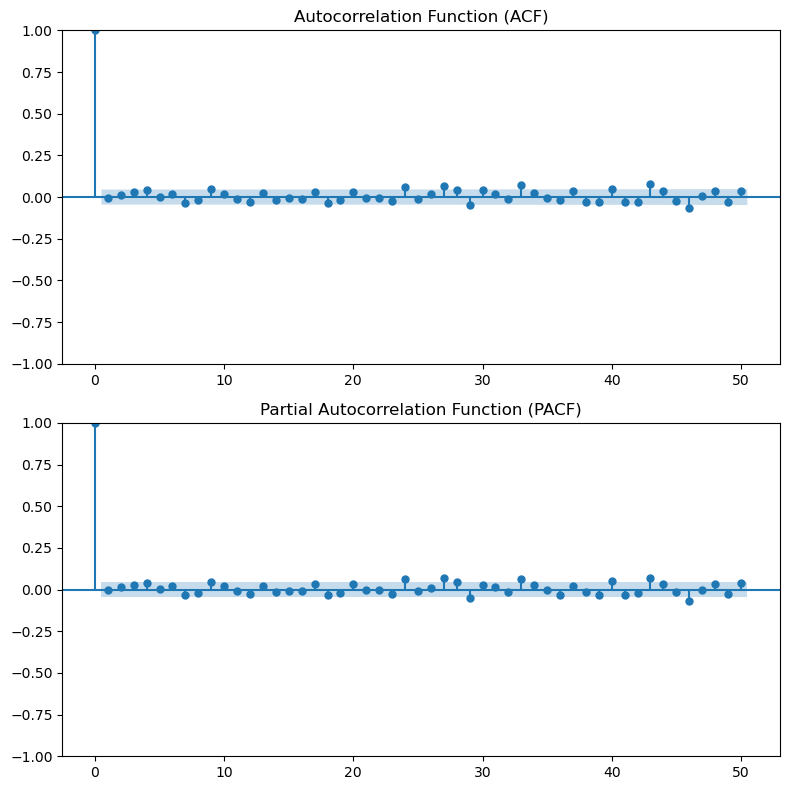

In [27]:
plot_acf_pacf(y_diff,50)

### The SARIMA model


In [28]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [29]:
def find_best_sarimax_params(data, max_ar=3, max_ma=3, max_s=3):
    p = d = q = range(0, max_ar) 
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(data,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                results = model.fit()

                if results.aic < best_aic:
                    best_aic = results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
            except:
                continue

    return best_pdq, best_seasonal_pdq


### Find the best SARIMA params

In [30]:
best_params = find_best_sarimax_params(y)
print('Best ARIMA params:', best_params[0])
print('Best seasonal params:', best_params[1])

Best ARIMA params: (0, 1, 2)
Best seasonal params: (0, 2, 2, 12)


### Fit SARIMA model

In [31]:
# specify the model
model = SARIMAX(y,
                order=best_params[0],              # specify your ARIMA order
                seasonal_order=best_params[1], # specify your seasonal order
                enforce_stationarity=False,   # depending on your data you might want to change these
                enforce_invertibility=False)

# fit the model
results = model.fit()

# get a summary of the model parameters and performance
print(results.summary())

# make predictions
pred = results.get_prediction(start=pd.to_datetime(BASE_DATE), dynamic=False)
pred_conf = pred.conf_int()

                                     SARIMAX Results                                      
Dep. Variable:                                BTC   No. Observations:                 1884
Model:             SARIMAX(0, 1, 2)x(0, 2, 2, 12)   Log Likelihood              -15375.268
Date:                            Tue, 05 Mar 2024   AIC                          30760.535
Time:                                    03:47:01   BIC                          30788.101
Sample:                                01-01-2019   HQIC                         30770.702
                                     - 02-27-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0012      0.016     -0.075      0.941      -0.032       0.030
ma.L2          0.0137      0.017   

## 4. Forecast

In [32]:

def plot_forecast(model_results, data, data_all, steps=6, start_date=None):
    # forecast for the next 'steps' periods
    forecast = model_results.get_forecast(steps=steps)
    forecast_ci = forecast.conf_int()

    # If a start date is provided, slice the data
    if start_date:
        data = data[start_date:]
        data_all = data_all[start_date:]

    # create a new row for the forecast confidence interval dataframe
    new_row = pd.DataFrame([[data.values[-1], data.values[-1]]], columns=forecast_ci.columns, index=[pd.to_datetime(data.index[-1])])

    # concatenate the new row and the original dataframe
    forecast_ci = pd.concat([new_row, forecast_ci])

    # set seaborn style
    sns.set(style='whitegrid')

    # set the figure size
    plt.figure(figsize=(16, 6))

    # plot the time series data
    sns.lineplot(data=data, color='k', label='Historical')
    sns.lineplot(data=data_all[BASE_DATE:], color='k', linestyle = 'dotted', label='Actual')


    forecast_index = pd.DatetimeIndex([data.index[-1]]).append(forecast.predicted_mean.index)
    forecast_values = np.append(np.array(data.values[-1]), forecast.predicted_mean.values)

    # plot your mean predictions
    sns.lineplot(x=forecast_index, y=forecast_values, color='b', label='Forecast')

    # shade the area between your confidence limits
    sns.lineplot(x=forecast_ci.index, y=forecast_ci.iloc[:, 0], color='r', alpha=0.1)
    sns.lineplot(x=forecast_ci.index, y=forecast_ci.iloc[:, 1], color='r', alpha=0.1)
    plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='b', alpha=0.1)

    plt.title('SARIMA model forecast for next {} periods'.format(steps))
    plt.xlabel('Date')
    plt.ylabel('Values')
    
    plt.axvline(x=BASE_DATE, c='gray', linewidth = 2.5, ls='--', alpha=0.8)

    plt.legend()
    plt.show()


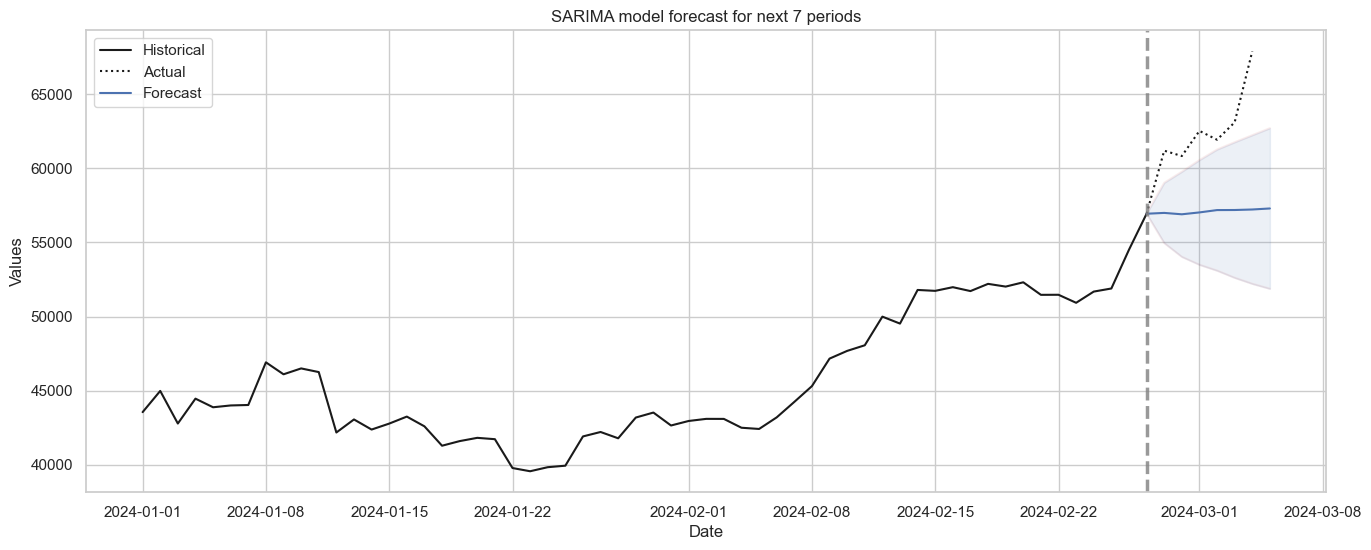

In [33]:
plot_forecast(results, y, df[TARGET_FEATURE],  PRED_STEPS, '2024-01-01')